# Generating statistics for subset of Wikidata

This notebook illustrates how to generate statistics for a subset of Wikidata. \
We use as an example https://www.wikidata.org/wiki/Q11173 (chemical compound).

Example Dataset wikidata subset: https://drive.google.com/drive/u/1/folders/1KjNwV5M2G3JzCrPgqk_TSx8wTE49O2Sx \
Example Dataset statistics: https://drive.google.com/drive/u/0/folders/1_4Mxd0MAo0l9aR3aInv0YMTJrtneh7HW 

### Example Invocation command

    papermill /Users/shashanksaurabh/Desktop/MS/ISI/isi/kgtk_shashank73744/kgtk/examples/Example_10_Wikidata_Subgraph_Statistics.ipynb \
    /Users/shashanksaurabh/Desktop/MS/ISI/isi/kgtk_shashank73744/kgtk/examples/Example_10_output.ipynb \
    -p wikidata_home '/Users/shashanksaurabh/Desktop/Data_isi' \
    -p wikidata_parts_folder '/Users/shashanksaurabh/Desktop/Data_isi/Chemical' \
    -p cache_folder '/Users/shashanksaurabh/Desktop/Data_isi/Temp' \
    -p output_folder '/Users/shashanksaurabh/Desktop/Data_isi/output' \
    -p delete_database 'yes' \
    -p K \"10\" \
    -p subset_name 'Q11173'


In [2]:
wikidata_home = "/Users/shashanksaurabh/Desktop/Data_isi"

# path to folder which contains all files corresponding to the wikidata subset. 
#(For more information on wikidata subset please check Example 8)
wikidata_parts_folder = "/Users/shashanksaurabh/Desktop/Data_isi/Chemical"

# The notebook creates a cache, which is present in the cache_folder. The cache can be deleted after the execution.
cache_folder = "/Users/shashanksaurabh/Desktop/Data_isi/Temp"

# path to the folder where the output (here statistics) would be stored
output_folder = "/Users/shashanksaurabh/Desktop/Data_isi/output"

# In each of statistics top K results are chosen.
#In the following examples this has been implemented using the --limit attribute.
K = "5"

# This represents the Qnode of wikidata subset.
subset_name = "Q11173"

In [3]:
import io
import os
import subprocess
import sys

import numpy as np
import pandas as pd

from IPython.display import display, HTML, Markdown, Image

from kgtk.kypher.sqlstore import *

import matplotlib.pyplot as plt

from qwikidata.sparql  import return_sparql_query_results

# import altair as alt
# alt.renderers.enable('altair_viewer')

# from IPython.display import display, HTML, Image
# from pandas_profiling import ProfileReport

In [4]:
try:
    int_k = int(K)
except Exception as e:
    int_k = int(K[1:-1])

### Set up environment variables and folders that we need

In [5]:
# path to folder which contains all files corresponding to the wikidata subset. 
#(For more information on wikidata subset please check Example 8)
os.environ['WIKIDATA_PARTS'] = wikidata_parts_folder

# path to the folder where the output (here statistics) would be stored
os.environ['OUTPUT_FOLDER'] = output_folder

# The statistics are stored in two different folders, overview folder and class folder.
# If the folders are not present then in the following command they are created
if not os.path.isdir(os.path.join(output_folder,"overview_folder")):
    os.mkdir(os.path.join(output_folder,"overview_folder"))
if not os.path.isdir(os.path.join(output_folder,"classes")):
    os.mkdir(os.path.join(output_folder,"classes"))
if not os.path.isdir(os.path.join(output_folder,"property_overview")):
    os.mkdir(os.path.join(output_folder,"property_overview"))

# Environmnet variable for the two sub folders where the statistics would be stored  
os.environ['OVERVIEW_FOLDER'] = os.path.join(output_folder,"overview_folder")
os.environ['CLASS_FOLDER'] = os.path.join(output_folder,"classes")
os.environ['PROPERTY_OVERVIEW'] = os.path.join(output_folder,"property_overview")

# kgtk command to run
os.environ['kgtk'] = "kgtk"
os.environ['kgtk'] = "time kgtk --debug"

# absolute path of the db
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(cache_folder)
os.environ['K'] = K
os.environ['label'] = subset_name + ".label.en.tsv.gz"

# file name corresponding to different part of the Wikidata subgraph.
os.environ['subset_name']  = subset_name
os.environ['external_id']  = subset_name + ".part.external-id.tsv.gz"
os.environ['time']  = subset_name +  ".part.time.tsv.gz"
os.environ['wikibase_item']  = subset_name + ".part.wikibase-item.tsv.gz"
os.environ['quantity']  = subset_name +  ".part.quantity.tsv.gz"
os.environ['statistics']  = subset_name + ".statistics.tsv.gz"
os.environ['wikibase_form']  = subset_name + ".part.wikibase-form.tsv.gz"
os.environ['monolingualtext']  = subset_name + ".part.monolingualtext.tsv.gz"
os.environ['math']  = subset_name + ".part.math.tsv.gz"
os.environ['commonsMedia']  = subset_name + ".part.commonsMedia.tsv.gz"
os.environ['globe_coordinate']  = subset_name + ".part.globe-coordinate.tsv.gz"
os.environ['musical_notation']  = subset_name + ".part.musical-notation.tsv.gz"
os.environ['geo_shape']  = subset_name + ".part.geo-shape.tsv.gz"
os.environ['url']  = subset_name + ".part.url.tsv.gz"
os.environ['string']  = subset_name + ".part.string.tsv.gz"
os.environ['alias']  = subset_name + ".alias.en.tsv.gz"
os.environ['description']  = subset_name + ".description.en.tsv.gz"

# Output file corresponding to the overview folder (contains overview part of the statistics)
os.environ['class_summary']  = subset_name + "_class_summary.tsv"
os.environ['top_pagrank']  = subset_name + "_top_pagrank.tsv"
os.environ['stats']  = subset_name + "_stats.tsv"
os.environ['all_degree']  = subset_name + "_allDegree.tsv"
os.environ['degree']  = subset_name + "_degree.tsv"
os.environ['class_summary']  = subset_name + "_class_summary.tsv"
os.environ['temp']  = subset_name + "_temp_tsv.tsv"
os.environ['magnitudes_destribution'] = subset_name + "_magnitude_destribution_for_quantity.tsv"
os.environ['year_destribution_per_deacade'] = subset_name + "_year_destribution_for_time_per_decade.tsv"
os.environ['year_destribution_per_50_years'] = subset_name + "_year_destribution_for_time_per_50_years.tsv"
os.environ['globe_coordinate_destribution'] = subset_name + "_coordinate_destribution_for_globe_coordinate.tsv"
os.environ['geo_shape_random_samples'] = subset_name + "_random_sample_for_geo_shape.tsv"

# Output files corresponding to the class summary folder (contains class summary part of the statistics)
os.environ['property_summary_external_id']  = subset_name + "_property_summary_externaID.tsv"
os.environ['property_summary_time']  = subset_name + "_property_summary_time.tsv"
os.environ['property_summary_wikibase_item']  = subset_name + "_property_summary_wikibaseItem.tsv"
os.environ['property_summary_quantity']  = subset_name + "_property_summary_Quantity.tsv"
os.environ['property_summary_wikibase_form']  = subset_name + "_property_summary_wikibaseForm.tsv"
os.environ['property_summary_monolingualtext']  = subset_name + "_property_summary_monoLingualText.tsv"
os.environ['property_summary_math']  = subset_name + "_property_summary_math.tsv"
os.environ['property_summary_commonsMedia']  = subset_name + "_property_summary_commonsMedia.tsv"
os.environ['property_summary_globe_coordinate']  = subset_name + "_property_summary_globeCoordinate.tsv"
os.environ['property_summary_musical_notation']  = subset_name + "_property_summary_musicalNotation.tsv"
os.environ['property_summary_geo_shape']  = subset_name + "_property_summary_geoShape.tsv"
os.environ['property_summary_url']  = subset_name + "_property_summary_url.tsv"
os.environ['property_summary_string']  = subset_name + "_property_summary_string.tsv"

In [31]:
FNULL = open(os.devnull, 'w')
def run_command(cmd, substitution_dictionary = {}):
    """Run a templetized command."""
    debug = False
    for k, v in substitution_dictionary.items():
        cmd = cmd.replace(k, v)
    
#     print(cmd)
    if debug:
        output = subprocess.run([cmd], shell=True, universal_newlines=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(output.stdout)
        print(output.stderr)
    else:
        output = subprocess.run([cmd], shell=True, universal_newlines=True, stdout=FNULL, stderr=subprocess.PIPE)
    #print(output.returncode)

In [7]:
# This function is used to print the string in different font, colors and font-size.
def printmd(string,color='black',size='25',fontWeight="bold"):
    colorstr = "<span style='font-weight: {};margin-top=80px;margin-bottom=80px; font-size:{}; color:{}'>{}</span>".format(fontWeight,str(size)+'px',color, string)
    display(HTML(colorstr))

In [8]:
# Its  a helper function which given a qnode or pnode returns the link corresponding to it.
def generate_link(string):
    if string[0] == 'P':
        return "https://www.wikidata.org/wiki/Property:"+string 
    elif string[0] == 'Q':
        return "https://www.wikidata.org/wiki/"+string
    return string

In [9]:
# It returns the label of the qnode
def find_label(qnode):
    try:
        query_string = """
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> \
                PREFIX wd: <http://www.wikidata.org/entity/> \
                SELECT  * \
                WHERE { \
                    wd:__qnode rdfs:label ?label . \
                    FILTER (langMatches( lang(?label), "EN" ) ) \
                  } \
                LIMIT 1
            """
        query_string = query_string.replace("__qnode",str(qnode))
        res = return_sparql_query_results(query_string)
#         print(query_string)
#         print(res)
        if 'results' in res and "bindings" in res['results'] and len(res['results']['bindings'])>=1 and "label" in res['results']['bindings'][0] and "value" in res['results']['bindings'][0]["label"] :
            return res['results']['bindings'][0]["label"]["value"].capitalize()
        return qnode
    except Exception as e:
        return qnode

In [10]:
#Types contain tuple of the environmnet variable corresponding to the input property file, 
#the name of the Datatype and environmnet variable corresponding to the output file.
types = [
        ("time","Time","property_summary_time"),
        ("wikibase_item","Wikibase_item","property_summary_wikibase_item"),
        ("math","Math","property_summary_math"),
        ("wikibase_form","Wikibase-form","property_summary_wikibase_form"),
        ("quantity","Quantity","property_summary_quantity"),
        ("string","String","property_summary_string"),
        ("external_id","External-id","property_summary_external_id"),
        ("commonsMedia","CommonsMedia","property_summary_commonsMedia"),
        ("globe_coordinate","Globe-coordinate","property_summary_globe_coordinate"),
        ("monolingualtext","Monolingualtext","property_summary_monolingualtext"),
        ("musical_notation","Musical-notation","property_summary_musical_notation"),
        ("geo_shape","Geo-shape","property_summary_geo_shape"),
        ("url","Url","property_summary_url"),
    ]
try:
    number_of_node = 0
    number_of_edges = 0
    number_of_classes = 0
    number_of_properties = 0
    for type_,name,file in types:
        temp = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv(type_)),delimiter='\t')
        number_of_properties += temp['label'].nunique()
        number_of_edges+=temp['node1'].count()
        if (name=="Wikibase_item"):
            number_of_node+=temp['node1'].nunique()
            number_of_classes = temp[temp['label']=='P279']['node2'].nunique()
    df_stats = pd.DataFrame([["Number of Nodes",number_of_node],["Number of Edges",number_of_edges],["Number of Classes",number_of_classes],["Number of Properties",number_of_properties]],columns=['Statistics', 'Value'])
    printmd("Overview of the Graph",'blue')
    printmd("Number of Nodes in the Graph: "+str(number_of_node),size=15,fontWeight='Light')
    printmd("Number of Edges in the Graph: "+str(number_of_edges),size=15,fontWeight='Light')
    printmd("Number of Classes in the Graph: "+str(number_of_classes),size=15,fontWeight='Light')
    printmd("Number of Properties in the Graph: "+str(number_of_properties),size=15,fontWeight='Light')
    df_stats.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('stats')),sep='\t')
except Exception as e:
    print(e)

In [87]:
try:
    # This query finds the statistics for all the nodes in wikibase_item and save it in a file
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$statistics --graph-cache $STORE \
    -o $OVERVIEW_FOLDER/$all_degree \
    --match 'item: (n1)-[l]->(n2), statistics:(n1)-[stats_property{label: llab}]->(stats) ' \
    --return 'distinct n1 as qnode, llab as `Property`, stats as Value' "
    run_command(cmd, {"__subset_name": subset_name})
    temp = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('all_degree')),delimiter='\t')
    indegree_avg  = temp[temp['Property']=='vertex_in_degree']['Value'].mean()
    indegree_min  = temp[temp['Property']=='vertex_in_degree']['Value'].min()
    indegree_max = temp[temp['Property']=='vertex_in_degree']['Value'].max()
    outdegree_avg  = temp[temp['Property']=='vertex_out_degree']['Value'].mean()
    outdegree_min  = temp[temp['Property']=='vertex_out_degree']['Value'].min()
    outdegree_max = temp[temp['Property']=='vertex_out_degree']['Value'].max()
    df_degree = pd.DataFrame([["in-degree",indegree_avg,indegree_min,indegree_max],["out-degree",outdegree_avg,outdegree_min,outdegree_max]],columns=["Stat","Average","Min","Max"])
    df_degree.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('degree')),sep='\t')
    printmd("Overview of the Graph",'blue')
    printmd("Average in-degree of the Graph: "+str(indegree_avg),size=15,fontWeight='Light')
    printmd("Minimum in-degree of the Graph: "+str(indegree_min),size=15,fontWeight='Light')
    printmd("Maximum in-degree of the Graph: "+str(indegree_max),size=15,fontWeight='Light')
    printmd("Average out-degree of the Graph: "+str(outdegree_avg),size=15,fontWeight='Light')
    printmd("Minimum out-degree of the Graph: "+str(int(outdegree_min)),size=15,fontWeight='Light')
    printmd("Maximum out-degree of the Graph: "+str(int(outdegree_max)),size=15,fontWeight='Light')
except Exception as e:
    print(e)

In [88]:
try:
    # This query finds all the classes based on number of Instances
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item -i $WIKIDATA_PARTS/$label -i $WIKIDATA_PARTS/$statistics --graph-cache $STORE \
    -o $OVERVIEW_FOLDER/$class_summary \
    --match 'item: (n1)-[l{label:llab}]->(n2), label: (n2)-[:label]->(label_n2),statistics:(n2)-[:vertex_pagerank]->(pagerank) ' \
    --return 'distinct n2 as Link, kgtk_lqstring_text(label_n2) as `Class_Label`, count(distinct n1) as `Number of Instances`, pagerank as Pagerank' \
    --where 'label_n2.kgtk_lqstring_lang_suffix = \"en\" AND (llab IN [\"P31\"])  ' \
    --order-by 'count(distinct n1) desc' "
    run_command(cmd)
    
    # Load the Dataframe with the file created in the above query
    df_class_summary = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('class_summary')),delimiter='\t')
    
    #The statistics for top K properties are generated and sum of Number of instances for 
    #the remaining properties are stored in other_instances
    other_instances = df_class_summary[int(int_k):]["Number of Instances"].sum()
    
    #Take top K properties and disregard rest of the properties
    df_class_summary = df_class_summary[:int(int_k)]
    
    #Take top K properties and disregard rest of the properties
    df_class_summary = df_class_summary[["Class_Label","Number of Instances","Pagerank","Link"]]
    
    df_class_summary = df_class_summary.append({"Class_Label":"Other Classes","Number of Instances":other_instances,"Pagerank":"NA","Link":"NA"},ignore_index=True)
    
    #Generate hyperlinks from the qnode/pnode
    df_class_summary['Link'] = df_class_summary['Link'].apply(generate_link)
    
    #Save the dataframe to the output file
    df_class_summary.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('class_summary')),sep='\t')
    printmd("Class Summary of the Subgraph",'blue')
    printmd("Below is the list of Top K Classes of the Subgraph ordered based on number of instances",size="15",fontWeight="Light")
    display(HTML(df_class_summary.to_html(index=False)))
except Exception as e:
    print(e)

Class_Label,Number of Instances,Pagerank,Link
chemical compound,1063060,0.0627481,https://www.wikidata.org/wiki/Q11173
medication,2507,0.000111443,https://www.wikidata.org/wiki/Q12140
diacylglycerophosphocholine,485,2.45038e-05,https://www.wikidata.org/wiki/Q63436503
carcinogen,479,2.7155e-05,https://www.wikidata.org/wiki/Q187661
wax monoester,410,2.07372e-05,https://www.wikidata.org/wiki/Q63446172
Other Classes,14172,NA,NA


In [89]:
try:
    df_property_summary = []

    #Types contain tuple of the environmnet variable corresponding to the input property file, 
    #the name of the Datatype and environmnet variable corresponding to the output file.
    types = [
        ("time","Time","property_summary_time"),
        ("wikibase_item","Wikibase Item","property_summary_wikibase_item"),
        ("math","Mathematical Expression","property_summary_math"),
        ("wikibase_form","Wikibase Form","property_summary_wikibase_form"),
        ("quantity","Quantity","property_summary_quantity"),
        ("string","String","property_summary_string"),
        ("external_id","External Id","property_summary_external_id"),
        ("commonsMedia","Common Media","property_summary_commonsMedia"),
        ("globe_coordinate","Globe Coordinate","property_summary_globe_coordinate"),
        ("monolingualtext","Monolingualtext","property_summary_monolingualtext"),
        ("musical_notation","Musical Notation","property_summary_musical_notation"),
        ("geo_shape","Geo Shape","property_summary_geo_shape"),
        ("url","Url","property_summary_url"),
    ]

    # This query finds all the properties ordered based on Number of Statements
    cmd = "$kgtk query  -i $WIKIDATA_PARTS/$TYPE_FILE -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
    -o $OVERVIEW_FOLDER/$output_file \
    --match 'part: (n1)-[l{label: llab}]->(n2), label: (llab)-[:label]->(label)' \
    --return 'distinct llab as Link, kgtk_lqstring_text(label) as `Property_Label`, count(llab) as `Number_of_Statements`' \
    --where 'label.kgtk_lqstring_lang_suffix = \"en\" ' \
    --order-by 'count(llab) desc '"
    
    # Do it for all the Datatypes
    for type,name, output_file in types:
        run_command(cmd, {"TYPE_FILE": type,"output_file":output_file})
        
        #Create dataframe object corresponding the file generated by the above command
        temp = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv(output_file)),delimiter='\t')
        
        #The statistics for top K properties are generated and sum of Number of statements for 
        #the remaining properties are stored in other_instances
        other_instances = temp[int(int_k):]["Number_of_Statements"].sum()
        
        #Take top K properties and disregard rest of the properties
        temp = temp[:int(int_k)]
        
        #Generated hyperlinks from the qnode/pnode
        temp['Link'] = temp['Link'].apply(generate_link)
        
        #Changing the order of the columns
        temp = temp[["Property_Label","Number_of_Statements","Link"]]
        
        temp = temp.append({"Property_Label":"Other Properties","Number_of_Statements":other_instances,"Link":"NA"},ignore_index=True)
        
        # Storing the temp to output file
        temp.to_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv(output_file)),sep='\t')
        
        # The output if there are no properties for a Datatype
        if len(temp) == 1:
            printmd("Datatype: "+name, 'blue')
            printmd("No Property is present for Datatype:" + name,size=15, fontWeight='Light')
            printmd("------------------------------------------------------------------------------------------")
            continue
        printmd("Datatype: "+name, 'blue')
        printmd("Below are the top K properties of Datatype:" + name +"  ordered based on number of statements",size =15,fontWeight='Light')
        df_property_summary.append(temp)
        display(HTML(df_property_summary[-1].to_html(index=False)))
        printmd("------------------------------------------------------------------------------------------")
except Exception as e:
    print(e)

Property_Label,Number_of_Statements,Link
time of discovery or invention,20,https://www.wikidata.org/wiki/Property:P575
discontinued date,1,https://www.wikidata.org/wiki/Property:P2669
inception,1,https://www.wikidata.org/wiki/Property:P571
service entry,1,https://www.wikidata.org/wiki/Property:P729
service retirement,1,https://www.wikidata.org/wiki/Property:P730
Other Properties,0,NA


Property_Label,Number_of_Statements,Link
catalog,49434,https://www.wikidata.org/wiki/Property:P972
has part,15973,https://www.wikidata.org/wiki/Property:P527
part of,9430,https://www.wikidata.org/wiki/Property:P361
medical condition treated,6121,https://www.wikidata.org/wiki/Property:P2175
active ingredient in,4178,https://www.wikidata.org/wiki/Property:P3780
Other Properties,15487,NA


Property_Label,Number_of_Statements,Link
mass,146546,https://www.wikidata.org/wiki/Property:P2067
melting point,9494,https://www.wikidata.org/wiki/Property:P2101
density,1113,https://www.wikidata.org/wiki/Property:P2054
defined daily dose,908,https://www.wikidata.org/wiki/Property:P4250
boiling point,873,https://www.wikidata.org/wiki/Property:P2102
Other Properties,6085,NA


Property_Label,Number_of_Statements,Link
chemical formula,344854,https://www.wikidata.org/wiki/Property:P274
canonical SMILES,199853,https://www.wikidata.org/wiki/Property:P233
isomeric SMILES,141589,https://www.wikidata.org/wiki/Property:P2017
Commons category,3463,https://www.wikidata.org/wiki/Property:P373
NIOSH Pocket Guide ID,615,https://www.wikidata.org/wiki/Property:P1931
Other Properties,1191,NA


Property_Label,Number_of_Statements,Link
InChIKey,997389,https://www.wikidata.org/wiki/Property:P235
InChI,990406,https://www.wikidata.org/wiki/Property:P234
CAS Registry Number,927660,https://www.wikidata.org/wiki/Property:P231
DSSTox substance ID,848585,https://www.wikidata.org/wiki/Property:P3117
PubChem CID,250629,https://www.wikidata.org/wiki/Property:P662
Other Properties,853651,NA


Property_Label,Number_of_Statements,Link
chemical structure,12520,https://www.wikidata.org/wiki/Property:P117
image,1992,https://www.wikidata.org/wiki/Property:P18
molecular model,20,https://www.wikidata.org/wiki/Property:P8224
pronunciation audio,17,https://www.wikidata.org/wiki/Property:P443
spoken text audio,6,https://www.wikidata.org/wiki/Property:P989
Other Properties,8,NA


Property_Label,Number_of_Statements,Link
coordinate location,1,https://www.wikidata.org/wiki/Property:P625
Other Properties,0,NA


Property_Label,Number_of_Statements,Link
World Health Organisation International Nonproprietary Name,2414,https://www.wikidata.org/wiki/Property:P2275
native label,13,https://www.wikidata.org/wiki/Property:P1705
short name,9,https://www.wikidata.org/wiki/Property:P1813
name,4,https://www.wikidata.org/wiki/Property:P2561
official name,1,https://www.wikidata.org/wiki/Property:P1448
Other Properties,3,NA


Property_Label,Number_of_Statements,Link
exact match,41,https://www.wikidata.org/wiki/Property:P2888
official website,26,https://www.wikidata.org/wiki/Property:P856
WordLift URL,4,https://www.wikidata.org/wiki/Property:P6363
Stack Exchange tag,1,https://www.wikidata.org/wiki/Property:P1482
equivalent class,1,https://www.wikidata.org/wiki/Property:P1709
Other Properties,3,NA


In [90]:
# This is a helper function which finds the Label corrponding to a qnode/pnode of the Subgraph
# return the label of the node if found otherwise empty string
#@parametes
#node: node for which label needs to returned
#df_label: Dataframe corresponding to the label
def label_node(node,df_label):
    for ele in df_label[df_label['node1']==node]['node2']:
        if kgtk_lqstring_lang(ele) == "en":
            return kgtk_lqstring_text(ele)
    return ""
        

In [91]:
# This is a helper function which finds all the superclasses of a class
# returns the list of superclasses
#@parameters
#Class: node for which all the superclasses needs to be returned
#df_wikibase_item: Dataframe corresponding to the wikibase item
#df_label: Dataframe corresponding to the label
def direct_superclasses(Class,df_wikibase_item,df_label):
    result = []
    corr_ele = df_wikibase_item[(df_wikibase_item['label']=='P279') & (df_wikibase_item['node1']==Class)]['node2']
    for ele in corr_ele.values.tolist():
        result.append(label_node(ele,df_label))
    return result

In [92]:
# This is a helper function which finds all the direct subclasses of a class
# returns the list of subclasses
#@parameters
#Class: node for which all the subclasses needs to be returned
#df_wikibase_item: Dataframe corresponding to the wikibase item
#df_label: Dataframe corresponding to the label
def direct_subclasses(Class,df_wikibase_item,df_label):
    result = []
    for i,ele in enumerate(df_wikibase_item[(df_wikibase_item['label']=='P279') & (df_wikibase_item['node2']==Class)]['node1'].values.tolist()):
        result.append(label_node(ele,df_label))
    return result

In [93]:
# This is a helper function which finds the statistics on the outcoming properties on the instances of the class
# returns a dataframe object with the statistics
#@parameters
#df_class_example: The dataframe object corresponding to the instances of the class
def find_properties(df_class_example):
    
    df_label = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('label')),delimiter='\t')

    #Environment variable corresponding to the statistics of each of the property data type
    types = [ "time",
             "wikibase_item",
             "math",
             "wikibase_form",
             "quantity",
             "string",
             "external_id",
             "commonsMedia",
             "globe_coordinate",
             "monolingualtext",
             "musical_notation",
             "geo_shape",
             "url"
            ]
    
    #This is a helper function which extract the qnode/pnode from the link
    def get_qnodes_from_link(link):
        return str(link.split("/")[-1])
    
    #This is a helper function checks if the node is present in instance_set or not
    def selected_qnode(node):
        return node in instance_set
    
    #Instance set is the set of all the qnodes of the instances of the class
    instance_set = set(list(df_class_example["Link"].map(get_qnodes_from_link)))
    
    #This is a helper function which finds the percentage corresponding to the passed value
    def find_percent(val):
        return round(val*100/number_of_instances,2)
    
    # This is a helper function which finds the label for the node
    def label_node(node):
        for ele in df_label[df_label['node1']==node]['node2']:
            if kgtk_lqstring_lang(ele) == "en":
                return kgtk_lqstring_text(ele)
        return node
    
    # Number of distinct qnodes in the example set.
    number_of_instances = len(instance_set)
    
    # Creating the data frame for the output
    df_all_prop = pd.DataFrame([],columns=['id','node1','label','node2'])
    for type_ in types:
        
        # Reading the property statistics of the type denoted by 'type_'
        df_temp = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv(type_)),delimiter='\t')
        
        # Selecting columns in the property statistics
        df_temp = df_temp[['node1','label']]
        
        # Finding all the statement which for the instances of the class
        df_temp = df_temp[df_temp['node1'].apply(selected_qnode)]
        
        df_temp = df_temp.reset_index()
        del df_temp["index"]
        
        # Dropping if there are many statements for same instances and same property
        # For example a node can have more than P31 statements
        df_temp = df_temp.drop_duplicates()
        df_all_prop = pd.concat([df_all_prop,df_temp])
    df_all_prop = df_all_prop.reset_index()
    
    # Finding the count for each of the properties
    df_all_prop = df_all_prop['label'].value_counts()
    df_all_prop = df_all_prop.reset_index()
    df_all_prop.columns = ["Property Name","Instances"]
    
    # Finding the Percent
    df_all_prop["% Instances"] = df_all_prop["Instances"].map(find_percent)
    df_all_prop["Property Name"] = df_all_prop["Property Name"].map(label_node)

    return df_all_prop

In [94]:
# This is a helper function which finds the statistics on the incoming properties on the instances of the class
# returns a dataframe object with the statistics
#@parameters
#df_class_example: The dataframe object corresponding to the instances of the class
def find_properties_incoming(df_class_example):
    
    df_label = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('label')),delimiter='\t')

    #Environment variable corresponding to the statistics of each of the property data type
    # Here wikibase_item is only relevant because it only has node2 as wikibase-item.
    types = [
             "wikibase_item"
            ]
    
    #This is a helper function which extract the qnode/pnode from the link
    def get_qnodes_from_link(link):
        return str(link.split("/")[-1])
    
    #This is a helper function checks if the node is present in instance_set or not
    def selected_qnode(node):
        return node in instance_set
    
    #Instance set is the set of all the qnodes of the instances of the class
    instance_set = set(list(df_class_example["Link"].map(get_qnodes_from_link)))
    
    # This is a helper function which finds the label for the node
    def label_node(node):
        for ele in df_label[df_label['node1']==node]['node2']:
            if kgtk_lqstring_lang(ele) == "en":
                return kgtk_lqstring_text(ele)
        return node
        
    # Number of distinct qnodes in the example set.
    number_of_instances = len(instance_set)
    
    # Creating the data frame for the output
    df_all_prop = pd.DataFrame([],columns=['id','node1','label','node2'])
    for type_ in types:
        
        # Reading the property statistics of the type denoted by 'type_'
        df_temp = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv(type_)),delimiter='\t')
        
        # Selecting columns in the property statistics
        df_temp = df_temp[['node2','label']]
        
         # Finding all the statement which for the instances of the class
        df_temp = df_temp[df_temp['node2'].apply(selected_qnode)]
        df_temp = df_temp.reset_index()
        del df_temp["index"]
        
        # Dropping if there are many statements for same instances and same property
        # For example a node can have more than P31 statements
        df_temp = df_temp.drop_duplicates()
        df_all_prop = pd.concat([df_all_prop,df_temp])
    df_all_prop = df_all_prop.reset_index()
    
    # Finding the count for each of the properties
    df_all_prop = df_all_prop['label'].value_counts()
    df_all_prop = df_all_prop.reset_index()
    df_all_prop.columns = ["Property Name","Instances"]
    df_all_prop["Property Name"] = df_all_prop["Property Name"].map(label_node)

    return df_all_prop

In [95]:
printmd('Class Overview','blue')
try:    
    # Load the list of classes generated in the  9th cell
    df = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('class_summary')),delimiter='\t')
    
    # Load the Descriptions of the nodes of the subgraph in a Dataframe
    df_description = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('description')),delimiter='\t')
    
    # Load the Aliases of the nodes  of the subgraph in a Dataframe
    df_alias = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('alias')),delimiter='\t')
    
    # Load the Wikibase item of the subgraph in a Dataframe
    df_wikibase_item = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('wikibase_item')),delimiter='\t')
    
    # Load the Labels of the nodes  of the subgraph in a Dataframe
    df_label = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('label')),delimiter='\t')

    #query to find the example instances of a class
    cmd = "$kgtk query -i $WIKIDATA_PARTS/$wikibase_item  -i $WIKIDATA_PARTS/$label -i $WIKIDATA_PARTS/$statistics  --graph-cache $STORE \
    -o $CLASS_FOLDER/__output_file \
    --match 'item: (n1)-[l{label:llab}]->(n2:__class), label: (n1)-[:label]->(label), statistics:(n1)-[:vertex_pagerank]->(pagerank)' \
    --return ' distinct n1 as Link, kgtk_lqstring_text(label) as `Label_`, pagerank as Pagerank' \
    --where 'label.kgtk_lqstring_lang_suffix = \"en\" AND llab in [\"P31\"]' \
    --order-by 'pagerank' "
    
    # Do for all the classes generated in the 9th cell
    for index, ele in df.iterrows():
        
        # Ignore the Other Classes part of the statistics
        if index==len(df)-1:
            continue;
        # Parse the Qnode from the  Link
        Current_Qnode = ele["Link"].split("/")[-1]
        
#         # Don't find the examples for the base class
#         if Current_Qnode ==  subset_name:
#             continue
            
        Number_of_instances_of_current_class = ele["Number of Instances"]
        
        # Heading
        printmd('Class: '+ ele["Class_Label"].capitalize(),'blue')
        
        # Find the list of all the description in English language
        description_array = [kgtk_lqstring_text(ele) for ele in df_description[df_description["node1"]==Current_Qnode]['node2'].values.tolist() if kgtk_lqstring_lang(ele) =='en']
        description_current = "".join(description_array[0] if len(description_array)>=1 else "")
        
        # Find the list of all the aliases in English language
        aliases_current = ", ".join([kgtk_lqstring_text(ele) for ele in df_alias[df_alias["node1"]==Current_Qnode]['node2'].values.tolist() if kgtk_lqstring_lang(ele) =='en'])
        
        # Find the list of all the subclasses in English language
        subclass_current = direct_subclasses(Current_Qnode,df_wikibase_item,df_label)
        
        # Find the list of all the super classes in English language
        direct_super_class_current = direct_superclasses(Current_Qnode,df_wikibase_item,df_label)
        
        # Print statments
        printmd('Description: '+ description_current.capitalize(),size=15, fontWeight='Light')
        printmd('Aliases: '+ aliases_current.capitalize(),size=15,fontWeight='Light')
        printmd('Direct Superclasses: '+ ", ".join(direct_super_class_current[:10]).capitalize(),size=15,fontWeight='Light')
        printmd('Direct Subclasses: '+ ", ".join(subclass_current[:10]).capitalize(),size=15,fontWeight='Light')
        printmd("Number of Instances: " +str(Number_of_instances_of_current_class),size=15,fontWeight='Light')
        printmd("Number of Superclasses: " +str(len(direct_super_class_current)),size=15,fontWeight='Light')
        printmd("Number of Subclasses: " +str(len(subclass_current)),size=15,fontWeight='Light')
        printmd("Examples for " + ele["Class_Label"] +" Class",'black',size=18)
        
        #Create a dataframe corresponding to the above generated statistics
        class_overview = pd.DataFrame([["Description",description_current.capitalize()],["Aliases",aliases_current.capitalize()],["Subclass of",", ".join(subclass_current).capitalize()],["Number of Instances",Number_of_instances_of_current_class],["Number of Subclass",len(subclass_current)],["Number of Superclass",len(direct_super_class_current)]],columns=["Stat","Value"])
        
        #Dynamically create the name of the output file where the example instances would be stored
        output_file = subset_name + "_" + ele["Class_Label"].replace(" ","-")+"_examples"+".tsv"
        
        output_file_prop = subset_name + "_" + ele["Class_Label"].replace(" ","-")+"_prop_destribution"+".tsv"
        
        output_file_prop_incoming = subset_name + "_" + ele["Class_Label"].replace(" ","-")+"_prop_destribution_incoming"+".tsv"
        
        #Dynamically create the name of the output file where the overview would be stored
        output_file_overview = subset_name + "_" + ele["Class_Label"].replace(" ","-")+"_overview"+".tsv"
        
        # Save the overview to the output file
        class_overview.to_csv(os.path.join(os.getenv('CLASS_FOLDER'),output_file_overview),sep='\t')
        
        # Find the example instances of the class
        run_command(cmd, {"__output_file": output_file,"__class": Current_Qnode})
        
        # Load the examples in a Dataframe
        df_class_example = pd.read_csv(os.path.join(os.getenv('CLASS_FOLDER'),output_file),delimiter='\t')
        
        # Change the order of the Columns
        df_class_example =  df_class_example[["Label_","Pagerank","Link"]]
        df_class_example['Link'] = df_class_example['Link'].apply(generate_link)
        df_class_example.to_csv(os.path.join(os.getenv('CLASS_FOLDER'),output_file),sep='\t')

        
        df_prop_all = find_properties(df_class_example)
        df_prop_all.to_csv(os.path.join(os.getenv('CLASS_FOLDER'),output_file_prop),sep='\t')

        
        display(HTML(df_class_example[:3].to_html(index=False)))
        
        printmd("Distribution of outgoing Properties from instances of " + ele["Class_Label"] +" Class",'black',size=18)
        display(HTML(df_prop_all[:10].to_html(index=False)))
        
        df_prop_incoming = find_properties_incoming(df_class_example)
        df_prop_incoming.to_csv(os.path.join(os.getenv('CLASS_FOLDER'),output_file_prop_incoming),sep='\t')
        
        printmd("Distribution of incoming Properties to instances of " + ele["Class_Label"] +" Class",'black',size=18)
        display(HTML(df_prop_incoming[:10].to_html(index=False)))

        printmd("------------------------------------------------------------------------------------------")
        
        
except Exception as e:
    display(e)

Label_,Pagerank,Link
patrinoside,0.000001,https://www.wikidata.org/wiki/Q27107631
acid blue 62,0.000001,https://www.wikidata.org/wiki/Q27276381
(ethylenedinitrilo)tetraacetonitrile,0.000001,https://www.wikidata.org/wiki/Q27286054


Property Name,Instances,% Instances
P31,1055956,100.00
InChIKey,992446,93.99
InChI,985520,93.33
CAS Registry Number,924660,87.57
DSSTox substance ID,846217,80.14
chemical formula,338297,32.04
PubChem CID,246097,23.31
SMILES,196683,18.63
mass,145639,13.79
isomeric SMILES,140044,13.26


Property Name,Instances
stereoisomer of,700
different from,310
has part,164
tautomer of,137
significant drug interaction,115
is a hydrated form of,103
P31,73
P279,48
part of,41
conjugate acid,13


Label_,Pagerank,Link
dulaglutide,0.000001,https://www.wikidata.org/wiki/Q21011228
tezacaftor,0.000001,https://www.wikidata.org/wiki/Q27270940
lobeglitazone,0.000001,https://www.wikidata.org/wiki/Q18350076


Property Name,Instances,% Instances
P31,2505,100.00
CAS Registry Number,2452,97.88
UNII,2412,96.29
DrugBank ID,2296,91.66
ChEMBL ID,2291,91.46
chemical formula,2260,90.22
InChIKey,2257,90.10
PubChem CID,2246,89.66
ChemSpider ID,2221,88.66
SMILES,2181,87.07


Property Name,Instances
significant drug interaction,112
different from,71
stereoisomer of,48
has part,31
is a hydrated form of,13
P279,6
P31,5
tautomer of,2
active ingredient in,1
P2868,1


Label_,Pagerank,Link
"1-hexadecanoyl-2-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphocholine",0.000001,https://www.wikidata.org/wiki/Q27105002
1-stearoyl-2-palmitoyl-sn-glycero-3-phosphocholine,0.000001,https://www.wikidata.org/wiki/Q27145082
1-palmitoyl-2-acetyl-sn-glycero-3-phosphocholine,0.000001,https://www.wikidata.org/wiki/Q27145169


Property Name,Instances,% Instances
LIPID MAPS ID,484,100.00
InChIKey,484,100.00
P31,484,100.00
isomeric SMILES,482,99.59
chemical formula,482,99.59
PubChem CID,482,99.59
InChI,482,99.59
mass,387,79.96
SMILES,387,79.96
ChemSpider ID,387,79.96


Property Name,Instances


Label_,Pagerank,Link
bromodichloroacetic acid,0.000001,https://www.wikidata.org/wiki/Q27289240
glycidaldehyde,0.000001,https://www.wikidata.org/wiki/Q2307855
aniline,0.000010,https://www.wikidata.org/wiki/Q186414


Property Name,Instances,% Instances
P31,479,100.00
CA PROP 65 ID,478,99.79
CAS Registry Number,477,99.58
InChIKey,475,99.16
DSSTox substance ID,473,98.75
InChI,471,98.33
ChemSpider ID,469,97.91
chemical formula,465,97.08
PubChem CID,464,96.87
SMILES,462,96.45


Property Name,Instances
different from,11
has part,6
significant drug interaction,5
P31,4
stereoisomer of,2
P279,1
polymer of,1
material used,1


Label_,Pagerank,Link
ethyl-2-nonynoate,0.000001,https://www.wikidata.org/wiki/Q27269581
cetyl myristate,0.000001,https://www.wikidata.org/wiki/Q27268650
2-pentyl butyrate,0.000001,https://www.wikidata.org/wiki/Q27285351


Property Name,Instances,% Instances
LIPID MAPS ID,410,100.00
P31,410,100.00
InChI,410,100.00
InChIKey,410,100.00
chemical formula,409,99.76
PubChem CID,409,99.76
SMILES,409,99.76
ChemSpider ID,408,99.51
mass,407,99.27
CAS Registry Number,394,96.10


Property Name,Instances
stereoisomer of,2
P31,1


In [10]:
try:    
    printmd('Property Overview','blue')
    
    # List of all the datatypes for the property and their tile.
    types = [
            ("property_summary_time","Time"),
            ("property_summary_wikibase_item", "Wikibase Item"),
            ("property_summary_math","Math"),
            ("property_summary_wikibase_form", "Wikibase Form"),
            ("property_summary_quantity", "Qunatity"),
            ("property_summary_string", "String"),
            ("property_summary_external_id","External Id"),
            ("property_summary_commonsMedia","Common Media"),
            ("property_summary_globe_coordinate", "Globe Coordinate"),
            ("property_summary_monolingualtext","Monolingual text"),
            ("property_summary_musical_notation", "Musical Notation"),
            ("property_summary_geo_shape", "Geo Shape"),
            ("property_summary_url",  "URL")
        ]
    
    # Create a new Dataframe to store the result.
    df_all_prop = pd.DataFrame([],columns=["Property_Label","Number_of_Statements","Link"])
    
    # For all types of the properties
    for type_, type_name in types:
        
        # Read the file generated above while calculating the statistics
        df_temp = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv(type_)),delimiter='\t')
        
        # Adding the column for the data type
        df_temp["Property Type"] = type_name
        
        # Concatenating the data frame
        df_all_prop = pd.concat([df_all_prop,df_temp])
        df_all_prop = df_all_prop.sort_values("Number_of_Statements",ascending=False).reset_index()
        del df_all_prop['index']
        del df_all_prop["Unnamed: 0"]
    
    # Removing the "Other Properties row" which was calculated earlier in the overview section
    df_all_prop = df_all_prop[df_all_prop["Property_Label"]!="Other Properties"]
    printmd("Top Ten Properties are ",'black',size=18)
    display(HTML(df_all_prop[:10].to_html(index=False)))
    df_all_prop.to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),"Top_Ten_Properties.tsv"),sep='\t')
except Exception as e:
    display(e)

Property_Label,Number_of_Statements,Link,Property Type
InChIKey,997389,https://www.wikidata.org/wiki/Property:P235,External Id
InChI,990406,https://www.wikidata.org/wiki/Property:P234,External Id
CAS Registry Number,927660,https://www.wikidata.org/wiki/Property:P231,External Id
DSSTox substance ID,848585,https://www.wikidata.org/wiki/Property:P3117,External Id
chemical formula,344854,https://www.wikidata.org/wiki/Property:P274,String
PubChem CID,250629,https://www.wikidata.org/wiki/Property:P662,External Id
canonical SMILES,199853,https://www.wikidata.org/wiki/Property:P233,String
mass,146546,https://www.wikidata.org/wiki/Property:P2067,Qunatity
isomeric SMILES,141589,https://www.wikidata.org/wiki/Property:P2017,String
catalog,49434,https://www.wikidata.org/wiki/Property:P972,Wikibase Item


In [103]:
try:    
    # Load the list of classes generated in the  9th cell
    df = pd.read_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),"Top_Ten_Properties.tsv"),delimiter='\t')
    
    # Load the Descriptions of the nodes of the subgraph in a Dataframe
    df_description = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('description')),delimiter='\t')
    
    # Load the Aliases of the nodes  of the subgraph in a Dataframe
    df_alias = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('alias')),delimiter='\t')

    
    # Load the Labels of the nodes  of the subgraph in a Dataframe
    df_label = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('label')),delimiter='\t')
    
    # Do for all the classes generated in the 9th cell
    for index, ele in df.iterrows():
        
        if index>=5:
            break;
        
        Current_Pnode = ele["Link"].split("/")[-1]
            
        Number_of_statements_of_current_property = ele["Number_of_Statements"]
        Property_type = ele["Property Type"]
        
        # Heading
        printmd('Property: '+ ele["Property_Label"].capitalize(),'blue')
        
        # Find the list of all the description in English language
        description_array = [kgtk_lqstring_text(ele) for ele in df_description[df_description["node1"]==Current_Pnode]['node2'].values.tolist() if kgtk_lqstring_lang(ele) =='en']
        description_current = "".join(description_array[0] if len(description_array)>=1 else "")
        
        # Find the list of all the aliases in English language
        aliases_current = ", ".join([kgtk_lqstring_text(ele) for ele in df_alias[df_alias["node1"]==Current_Pnode]['node2'].values.tolist() if kgtk_lqstring_lang(ele) =='en'])

        
        # Print statments
        printmd('Description: '+ description_current.capitalize(),size=15, fontWeight='Light')
        printmd('Aliases: '+ aliases_current.capitalize(),size=15,fontWeight='Light')
        printmd("Number of Statements:  " +str(Number_of_statements_of_current_property),size=15,fontWeight='Light')
        printmd("Property Type: " +str(Property_type),size=15,fontWeight='Light')
        
        #Create a dataframe corresponding to the above generated statistics
        property_overview = pd.DataFrame([["Description",description_current.capitalize()],["Aliases",aliases_current.capitalize()],["Number of Statements: ",str(Number_of_statements_of_current_property)],["Property Type: ",str(Property_type)]],columns=["Stat","Value"])
        
        
        #Dynamically create the name of the output file where the overview would be stored
        output_file_overview = subset_name + "_" + ele["Property_Label"].replace(" ","-")+"_overview"+".tsv"
        
        # Save the overview to the output file
        property_overview.to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_overview),sep='\t')
        
        printmd("------------------------------------------------------------------------------------------")
except Exception as e:
    display(e)

Unit,Number_of_Statements
Dalton,146073
Gram per mole,457
Kilodalton,1


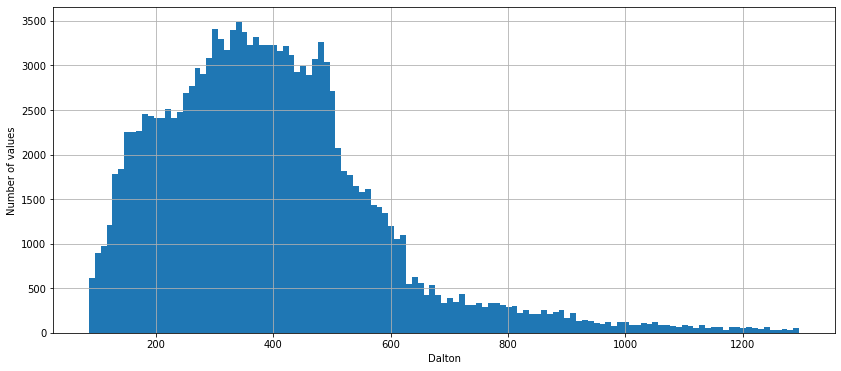

Unit,Number_of_Statements
Degree celsius,8975
Degree fahrenheit,506
Kelvin,10
NaN,3


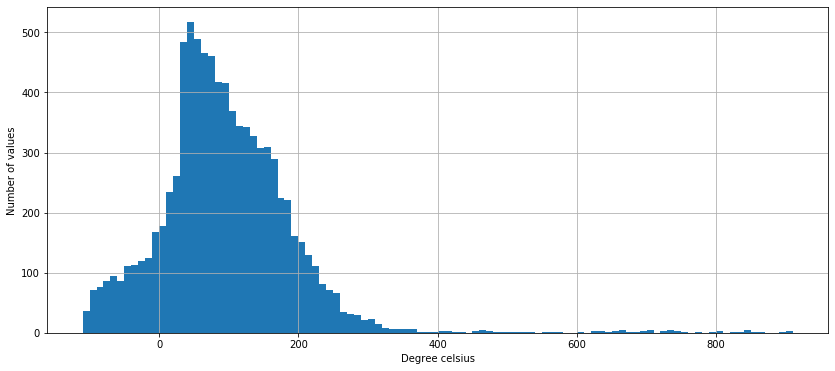

Unit,Number_of_Statements
Gram per cubic centimetre,1095
Kilogram per cubic metre,8
Gram per litre,7
Gram per cubic metre,3


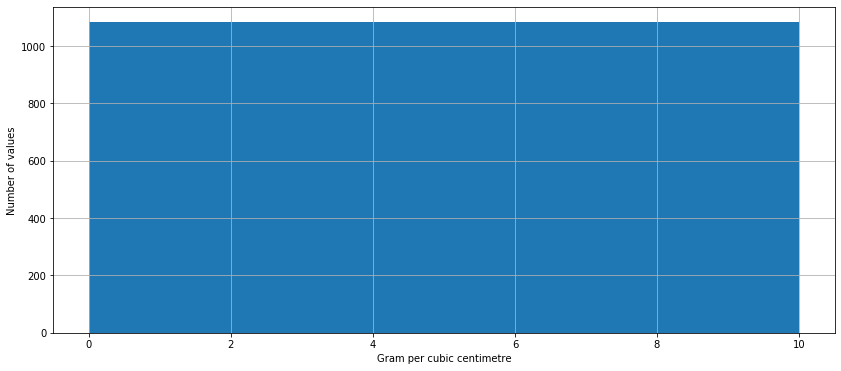

Unit,Number_of_Statements
Milligram,460
Gram,426
Microgram,18
Millilitre,4


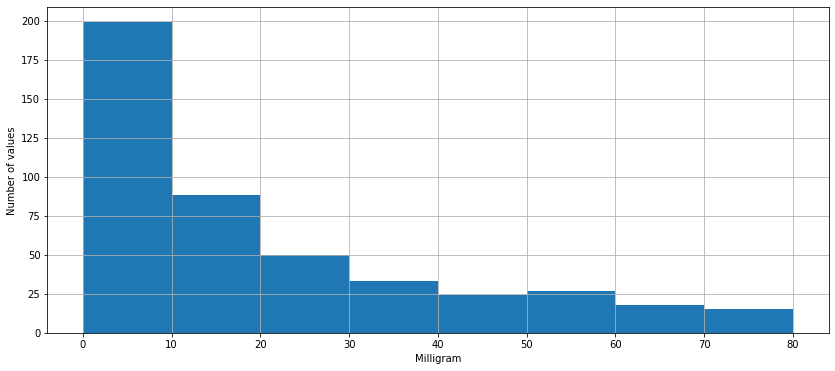

Unit,Number_of_Statements
Degree fahrenheit,414
Degree celsius,334
Kelvin,124


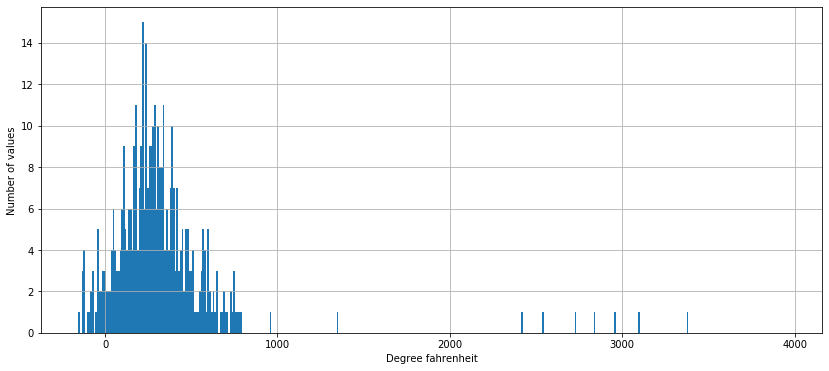

<Figure size 432x288 with 0 Axes>

In [15]:
# try:
#This Kypher querry can be used to find the destribution of all the units for a property
cmd1 = "$kgtk query -i $WIKIDATA_PARTS/$quantity --graph-cache $STORE \
        -o $PROPERTY_OVERVIEW/_output_file \
        --match  '(n1)-[r{label:llab}]->(v)' \
        --return 'distinct kgtk_quantity_wd_units(v) as Unit , count(n1) as Number_of_Statements ' \
        --where 'kgtk_quantity(v) AND (llab in [\"_prop\"])' \
        --order-by 'count(n1) desc' "

#This Kypher qurry can be used to find all the statements corresponding to a unit and a property 
cmd2 = "$kgtk query -i $WIKIDATA_PARTS/$quantity --graph-cache $STORE \
        -o $PROPERTY_OVERVIEW/_output_file \
        --match  '(n1)-[r{label:llab}]->(v)' \
        --return 'kgtk_quantity_number_int(v) as Magnitude ' \
        --where 'kgtk_quantity(v) AND (kgtk_quantity_wd_units(v) in [\"__unit\"]) AND (llab in [\"_prop\"])' "

#Initializing the dataframe pd_quantity_property with the list of top properties of datatype:quantity found above in the notebook  
pd_quantity_property = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('property_summary_quantity')),delimiter='\t')

#Iterating over all the rows of dataframe
for index,ele in pd_quantity_property.iterrows():

    #Ignoring the 'Other Instances' row
    if index>=int_k or ele['Property_Label'] =="Other Properties":
        break;

    # Extracting the "Pnode" corresponding to the property
    pnode = ele['Link'].split('/')[-1].split(":")[-1]
    
    print()

    #Extracting the 'Label' corresponding to the property
    prop_label = ele['Property_Label'].replace(" ","_")

    #Dynamically setting the name of the output file based on the name of property
    output_file_units_destribution = prop_label + "_units_destribution.tsv"

    #Running command 1
    run_command(cmd1,{"_output_file":output_file_units_destribution,"_prop":pnode})

    #Loading the destribution of quantities for a property in a dataframe
    pd_unit_destribution = pd.read_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_units_destribution),delimiter='\t')
    
    pd_unit_destribution_display =pd_unit_destribution .copy()
    pd_unit_destribution_display["Unit"] = pd_unit_destribution_display["Unit"].map(find_label)
    
    #Saving the file after mapping qnode with label
    pd_unit_destribution_display.to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_units_destribution),sep='\t')
    
    #Displaying the destribution of qunatities for a property
    printmd("Below is the distribution of units for " + prop_label + " in the subgraph",'blue')
    display(HTML(pd_unit_destribution_display.to_html(index=False)))

    #Finding the most prevalent unit
    if len(pd_unit_destribution)>=1:

        #Finding the most prevalent unit
        most_prevalent_unit_qnode = pd_unit_destribution.iloc[0]['Unit']
        most_prevalent_unit_label = pd_unit_destribution_display.iloc[0]["Unit"]
        
        # Dynamically setting the name of output file corresponding to the magnitude destrbution of most prevalent unit
        output_file_magnitude_destribution = prop_label +"_" + most_prevalent_unit_label.replace(" ","_") + "_magnitude_destribution.tsv"

        # Running Command 2 
        run_command(cmd2,{"_output_file":output_file_magnitude_destribution,"_prop":pnode,"__unit":most_prevalent_unit_qnode})

        # Loading the destribution of the magnitudes for a property and unit in a dataframe
        magnitude_distribution = pd.read_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_magnitude_destribution),delimiter='\t')
    
        # Binnig the magnitudes for displaying the histogram
        bin_values = np.arange(start=magnitude_distribution.quantile(.01)['Magnitude'], stop=magnitude_distribution.quantile(.99)['Magnitude'], step=10)
#         bin_values = np.arange(start=min(magnitude_distribution['Magnitude']), stop=max(magnitude_distribution['Magnitude']), step=10)

        
        #Displaying the histogram
        printmd('Below is a histogram of distribution of values for unit: "'+most_prevalent_unit_label +'" for ' + prop_label + ' in the subgraph (binned on an interval of 10 units)','blue')
        magnitude_distribution['Magnitude'].hist(bins=bin_values, figsize=[14,6])
        magnitude_distribution = magnitude_distribution['Magnitude'].value_counts(bins=bin_values, sort=False)
        
        plt.xlabel(most_prevalent_unit_label)
        plt.ylabel("Number of values")
        plt.show()
        plt.figure()
       
        #Saving the file 
        magnitude_distribution.to_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_magnitude_destribution),sep='\t')
# except Exception as e:
#     print(e)

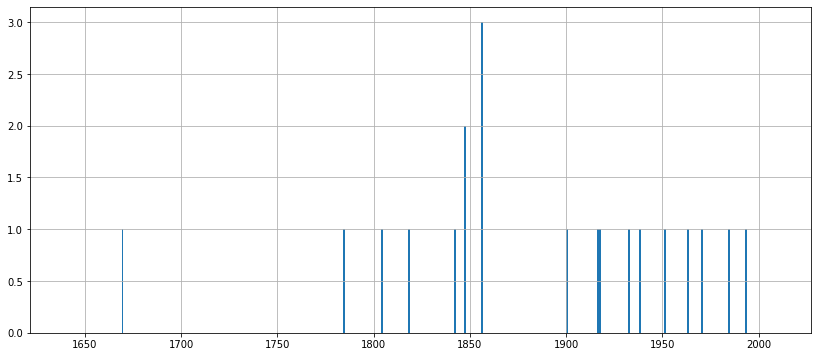

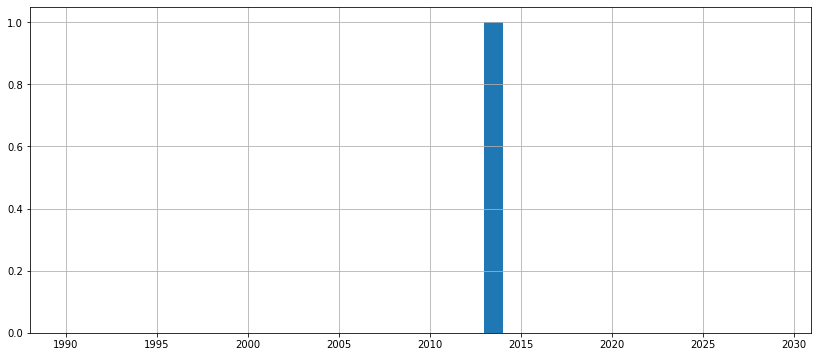

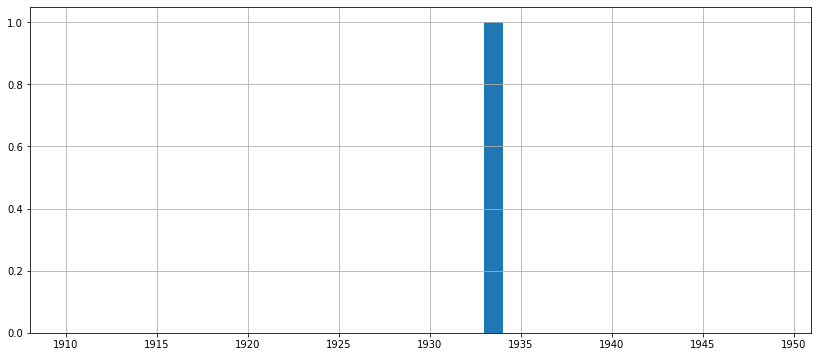

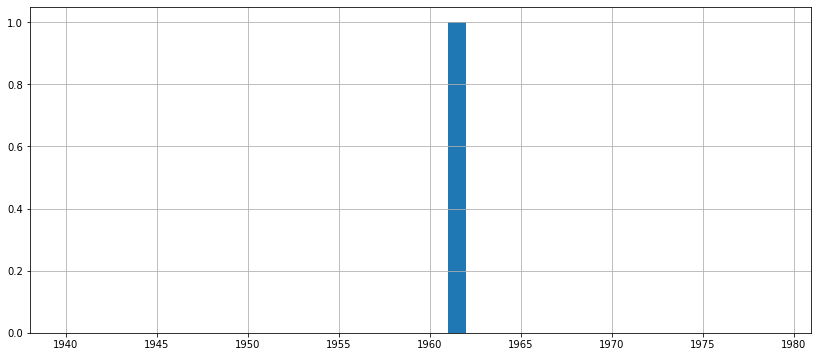

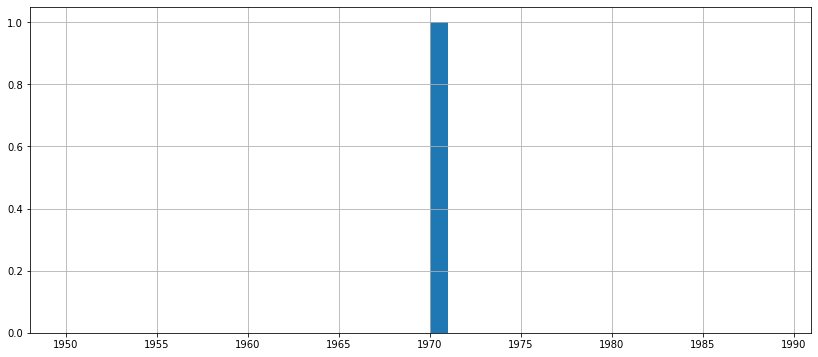

In [32]:
cmd = "$kgtk query -i $WIKIDATA_PARTS/$time --graph-cache $STORE \
        -o $PROPERTY_OVERVIEW/_output_file \
        --match  '(n1)-[r{label:llab}]->(v)' \
        --return 'kgtk_date_year(v) as Year' \
        --where 'kgtk_date(v) AND llab in [\"_prop\"] '"

#Initializing the dataframe pd_time_property with the list of top properties of datatype:time found above in the notebook  
pd_time_property = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('property_summary_time')),delimiter='\t')


for index,ele in pd_time_property.iterrows():
    
    #Ignoring the 'Other Instances' row
    if index>=int_k or ele['Property_Label'] =="Other Properties":
        break;

    # Extracting the "Pnode" corresponding to the property
    pnode = ele['Link'].split('/')[-1].split(":")[-1]
    
    print()

    #Extracting the 'Label' corresponding to the property
    prop_label = ele['Property_Label'].replace(" ","_")

    #Dynamically setting the name of the output file based on the name of property
    output_file_time_destribution = prop_label + "_time_destribution.tsv"

    #Running command 1
    run_command(cmd,{"_output_file":output_file_time_destribution,"_prop":pnode})    
        
    # Loading the destribution of the time for a property in a dataframe
    time_distribution = pd.read_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_time_destribution),delimiter='\t')
    
    # The smallest year in the dataframe
    min_year = min(time_distribution['Year'])
    
    # The largest year in the dataframe
    max_year = max(time_distribution['Year'])
    
    
    printmd("Below is a histogram for the distribution of '" + prop_label + "' binned per year" ,'blue')
    
    bin_values = np.arange(start=((min_year-20)//10)*10, stop=((max_year+20)//10)*10, step=1)
    
    
    time_distribution['Year'].hist(bins=bin_values, figsize=[14,6])
    
    plt.show()
    

In [43]:
cmd = "$kgtk query  -i $WIKIDATA_PARTS/$globe_coordinate -i $WIKIDATA_PARTS/$label --graph-cache $STORE \
       -o $PROPERTY_OVERVIEW/_output_file \
       --match 'part: (n1)-[l{label:llab}]->(n2)' \
       --return 'distinct n2 as coordinate, kgtk_geo_coords_lat(n2) as latitude, kgtk_geo_coords_long(n2) as longitude, count(n2) as Number_of_points  '\
       --where 'llab in [\"_prop\"]' \
       --order-by 'count(n2) desc'"

#Initializing the dataframe pd_time_property with the list of top properties of datatype:time found above in the notebook  
pd_coord_property = pd.read_csv(os.path.join(os.getenv('OVERVIEW_FOLDER'),os.getenv('property_summary_globe_coordinate')),delimiter='\t')
for index,ele in pd_coord_property.iterrows():
    #Ignoring the 'Other Instances' row
    if index>=int_k or ele['Property_Label'] =="Other Properties":
        break;

    # Extracting the "Pnode" corresponding to the property
    pnode = ele['Link'].split('/')[-1].split(":")[-1]
    
    print()

    #Extracting the 'Label' corresponding to the property
    prop_label = ele['Property_Label'].replace(" ","_")

    #Dynamically setting the name of the output file based on the name of property
    output_file_coord_destribution = prop_label + "_coord_destribution.tsv"

    #Running command 1
    run_command(cmd,{"_output_file":output_file_coord_destribution,"_prop":pnode})    
        
    # Loading the destribution of the time for a property in a dataframe
    coordinate_destribution = pd.read_csv(os.path.join(os.getenv('PROPERTY_OVERVIEW'),output_file_coord_destribution),delimiter='\t')
    
    printmd("Below is the distribution of '" + prop_label + "'" ,'blue')
    display(HTML(coordinate_destribution.to_html(index=False)))


coordinate,latitude,longitude,Number_of_points
@37.25/27,37.25,27.0,1


In [112]:
try:
    df = pd.read_csv(os.path.join(os.getenv('WIKIDATA_PARTS'),os.getenv('geo_shape')),delimiter='\t',index_col=False)
    try:
        num_rows = min(int(K[1:-1]),len(df))
    except Exception as e:
        num_rows = min(int(K),len(df))
    df.sample(n=num_rows)
    display(df)
    df.to_csv(os.path.join(os.getenv('OUTPUT_FOLDER'),os.getenv('geo_shape_random_samples')),sep='\t',index=False)
except Exception as e:
    print(e)

,id,node1,label,node2
